# Testing genomic context bias on gain/loss classifications

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("../../output/gain_loss_classifications.csv")
df.loc[:,"length_diff_hm"] = df.loc[:,"exon_diff_hm_raw"]
df = df.loc[:,["gene_id", "cell_type", "length_diff_hm", "gc_diff_hm", "class"]]
df.head()

gene_id  cell_type  length_diff_hm  gc_diff_hm         class
0  ENSMUSG00000034761  astroglia        0.884606   -0.203297  08_ambiguous
1  ENSMUSG00000034761    GABA_DN        0.884606   -0.203297  08_ambiguous
2  ENSMUSG00000034761         GC        0.884606   -0.203297  08_ambiguous
3  ENSMUSG00000034761    glut_DN        0.884606   -0.203297  08_ambiguous
4  ENSMUSG00000034761     immune        0.884606   -0.203297  08_ambiguous

In [3]:
cell_types = set(df.cell_type)
cell_types

{'GABA_DN',
 'GC',
 'NTZ_mixed',
 'NTZ_neuroblast',
 'Purkinje',
 'UBC',
 'VZ_neuroblast',
 'astroglia',
 'glut_DN',
 'immune',
 'interneuron',
 'isth_N',
 'meningeal',
 'oligo',
 'parabrachial'}

In [4]:
use_cell_types = ["GC", "Purkinje", "astroglia", "UBC"]

## Building a RF model

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
df.head()

gene_id  cell_type  length_diff_hm  gc_diff_hm         class
0  ENSMUSG00000034761  astroglia        0.884606   -0.203297  08_ambiguous
1  ENSMUSG00000034761    GABA_DN        0.884606   -0.203297  08_ambiguous
2  ENSMUSG00000034761         GC        0.884606   -0.203297  08_ambiguous
3  ENSMUSG00000034761    glut_DN        0.884606   -0.203297  08_ambiguous
4  ENSMUSG00000034761     immune        0.884606   -0.203297  08_ambiguous

GC


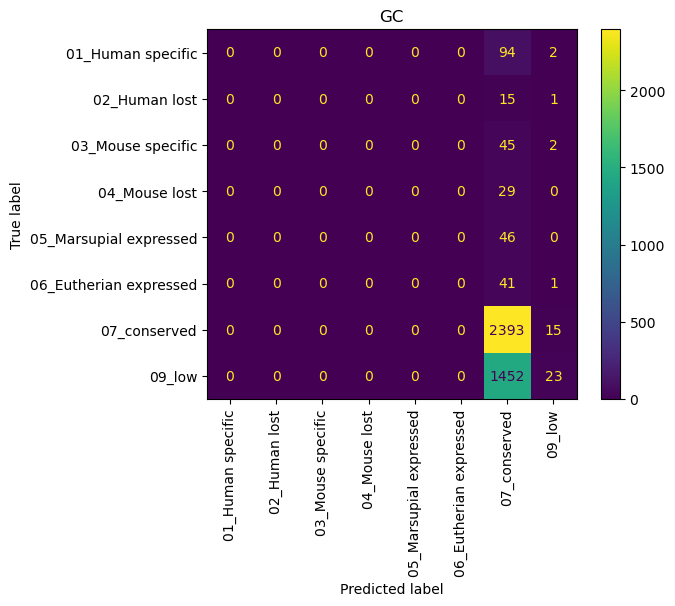

Purkinje


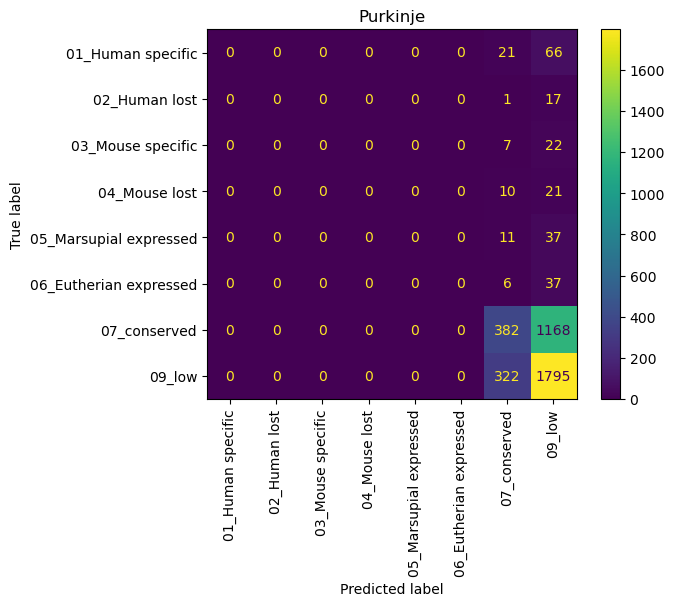

astroglia


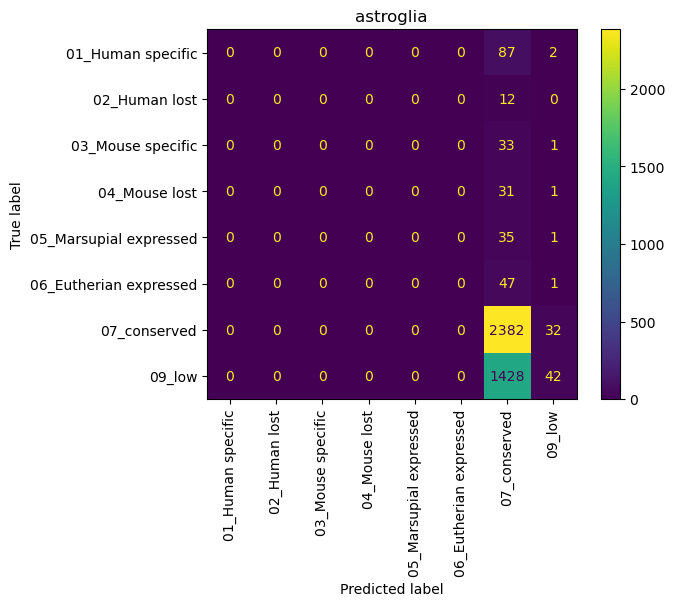

UBC


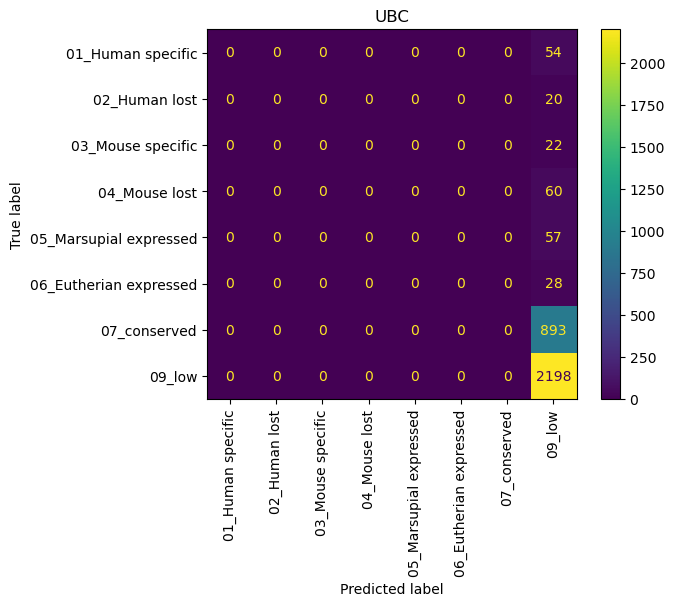

In [7]:
out = dict()
for ct in use_cell_types:
    print(ct)
    tmp = df.loc[df.loc[:,"cell_type"] == ct,:]
    tmp = tmp.loc[~tmp['class'].isin(["08_ambiguous","not analysed"]),:]
    
    tmp = tmp.sort_values('class')
    
    labels = list(set(tmp['class']))
    labels.sort()
    
    X = tmp.iloc[:,3:4]
    
    y = tmp.loc[:,"class"]
    
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, 
        stratify=y)
    
    clf = RandomForestClassifier(max_depth = 2, random_state = 1234)
    
    clf.fit(x_train, y_train)
    
    # prediciting on all available data, not only on the test set
    # normally this would increase the recall for the model 
    # since it "saw" the data before.
    Y = clf.predict(X)
    
    out[ct] = {"pred": Y,
               "gt": y,
               "model": clf,
               "data": tmp}
    

    disp = ConfusionMatrixDisplay(confusion_matrix(out[ct]['gt'],
                                  out[ct]['pred'],
                                  labels = clf.classes_),
                                  display_labels=clf.classes_)
    
    disp.plot()
    plt.xticks(rotation=90)
    plt.title(ct)
    plt.savefig(f"../../output/figures/rf_predictions/{ct}.pdf", bbox_inches="tight")
    plt.show()